# 0.0. IMPORTS

In [52]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import datetime
from tabulate import tabulate

# import jtplot submodule from jupyterthemes
#from jupyterthemes import jtplot
# currently installed theme will be used to
# set plot style if no arguments provided
#jtplot.style()

from IPython.core.display import display, HTML

# retira a margem do notebook
display(HTML("<style>.container { width:100% !important; }</style>"))

# font do texto markdown
display(HTML("<style>h1 { font-size:22px !important; }</style>"))
display(HTML("<style>h2 { font-size:20px !important; }</style>"))
display(HTML("<style>h3 { font-size:17px !important; }</style>"))
display(HTML("<style>h4 { font-size:16px !important; }</style>"))
display(HTML("<style>p { font-size:16px !important; }</style>"))

# tamanho da fonte da tabela
display(HTML("<style>th { font-size:15px !important; }</style>"))
display(HTML("<style>td { font-size:15px !important; }</style>"))

# font do codigo 
display(HTML("<style>span { font-size:16px !important; }</style>"))

ModuleNotFoundError: No module named 'tabulate'

## 0.0.1 Settings

   jt -t monokai -T -N -f roboto -fs 12 -cellw 93% -lineh 185 -ofs 10

## 0.1. Helper functions

## 0.2. Loading Data

In [2]:
# False makes an eager reading, instead of lazy reading
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False) 
df_store_raw = pd.read_csv('data/store.csv', low_memory=False) 

# merge the sales with the store, because store contains adittional informationo about
# the stores
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [3]:
df_sales_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
754620,551,6,2013-08-24,4163,756,1,0,0,0


# 1.0. Data Description

## 1.0.1 Saving the past data

In [4]:
# By creating a copy of the dataframe in each section you can speed up the process of
# recovering the original data if you overwrite it unintencionally
df1 = df_raw.copy()

## 1.1. Rename Columns

Generally the columns come from a database, so the columns' name are given by
backend engineers and not always these names are easy to remember, then its important to 
rename the columns to speed up the data analysis project.

In [5]:
cols_old = df1.columns
cols_old

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
snakecase = lambda x : inflection.underscore(x)

# map applies a lambda function to something
cols_new = list( map( snakecase, cols_old) )
print(cols_new)

# rename
df1.columns = cols_new
print(df1.columns)

['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo_interval']
Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')


## 1.2. Data Dimensions 

In [7]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 1017209
Number of columns: 18


## 1.3. Data Types 

In [8]:
# In pandas, object refers to strings, and pandas assumes that everything that is not
# an int or float is an object

# Converting date from object to date
df1['date'] = pd.to_datetime( df1['date'] )
print(df1.dtypes)

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object


## 1.4. Check NA

 NA refers to Not Aplicable or Not Available

#### There are 3 ways to treat NA
> Remove the NA 

>> Advantages: Its quick and easy to do

>> Disadvantages: You loose data
              
 > Change the NA by the mean or the median
 
 > Understand the NA by business view 

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

### competition_distance

 Assumptions to the NA value: the competitor is really far from the store, so it's like it doesnt exist, 
 
 Assume: if we assume a really big distance, bigger than the maximum distance, it
 will be well represented.

In [10]:
competition_distance_max = df1['competition_distance'].max()

In [11]:
# competition_distance - the NA will be replaced by 2000 * competition_distance_max
df1['competition_distance'] = df1['competition_distance'].apply(lambda x : (2000 * competition_distance_max) if math.isnan(x) else x)

### competition_open_since_month / year

Assumptions to the NA value: 

1-) The competitors store was opened before the store

2-) The competitors store was opened after the store, but someone forgot to take note of it

Assume: we can fill this with the date of the sell, because in the future we can use this
information to show what happened with the sells since the appearance of the nearest competitor.

In [12]:
# axis = 1, apply function in each row

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x : x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1)

### promo2_since_week / year

Assumptions to the NA value: 

1-) The store decided to not participate of promo 2

Assume: we can fill this with the date of the sell, because in the future we can use this
information to show what happened with the sells since the store decided to not participate of promo 2

In [13]:
# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x : x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

### promo_interval

In [14]:
# promo_interval   
month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 
            8: 'Aug', 9: 'Sep', 10: 'Out', 11: 'Nov', 12: 'Dec'}

# inplace=True do the modification directly in the object instead of returning the modification
df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo2'] = df1[['promo_interval', 'month_map']].apply(lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)  

In [15]:
df1.sample(5).T

,924074,27967,344866,421631,13725
store,525,93,30,947,346
day_of_week,1,1,6,4,7
date,2013-03-25 00:00:00,2015-07-06 00:00:00,2014-09-06 00:00:00,2014-06-19 00:00:00,2015-07-19 00:00:00
sales,12367,5779,4247,0,0
customers,962,602,668,0,0
open,1,1,1,0,0
promo,1,0,0,1,0
state_holiday,0,0,0,a,0
school_holiday,1,1,0,1,0
store_type,d,a,a,a,a


## 1.6 Change Types

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo2                                int64
dtype: object

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo2                                int64
dtype: object

## 1.7. Descriptive Statistics

### Split the data between numerical and categorial data

In [18]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### Central Tendency Metrics 
- Mean, Median 
- Can represent a set of numbers using just one number
- When the mean and the median are almost equal, represents that there arent many 
    outliers, and we can think about a normal as a good distribution to our model

### Dispersive Metrics 
- Variance, Standard Deviation, Min, Max, Range, Skew, kurtosis 
- Show if the set of numbers are concentratred or sparsed
- Skew: 
<img src="https://upload.wikimedia.org/wikipedia/commons/6/63/Skew_normal_densities.svg" style="width:40%; height:40%; margin-left:10%;"/>
- Kurtosis: 
<img src="https://upload.wikimedia.org/wikipedia/commons/3/33/Standard_symmetric_pdfs.svg" style="width:40%; height:40%; margin-left:10%; background-color: #f2f2f2"/>


In [19]:
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
# Calculating the range
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,3.219085e+02,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390e+00,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3.849924e+03,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,4.644115e+02,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,3.755390e-01,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,4.857584e-01,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,3.830562e-01,1.677842,0.815154
7,competition_distance,20.0,151720000.0,151719980.0,399478.795125,2330.0,7.721898e+06,19.545264,380.018477
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085e+00,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591e+00,-7.235657,124.071304


/home/gabriel/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

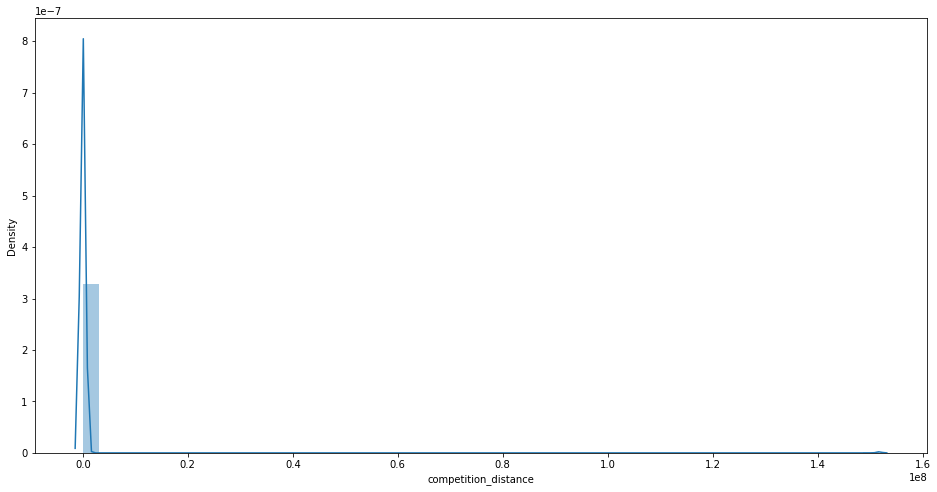

In [20]:
plt.figure(figsize=(16, 8))
sns.distplot( df1['competition_distance'] )

In [21]:
# Categorical attributes
cat_attributes.apply(lambda x : x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

### Search about boxplots

<AxesSubplot:xlabel='assortment', ylabel='sales'>

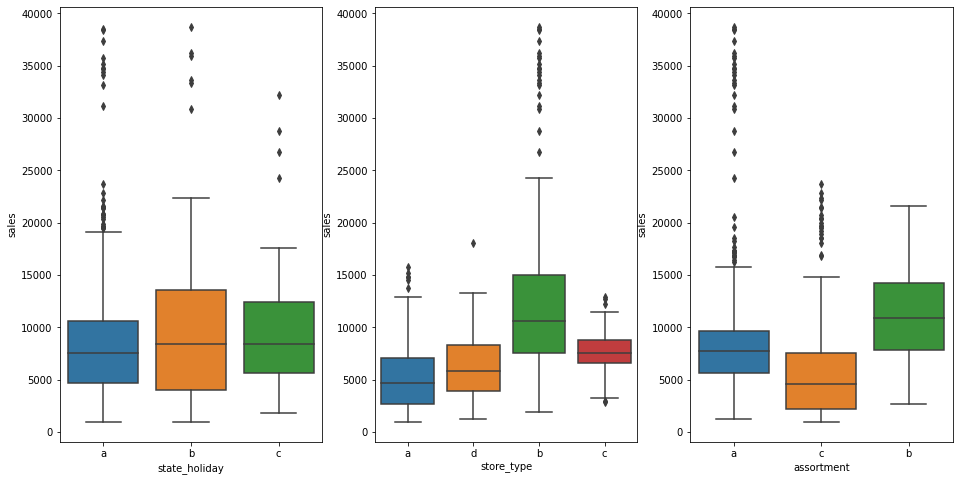

In [22]:
# If it was a state holiday and the sales were bigger than 0, that is the store was not
# closed
aux1 = df1[ (df1['state_holiday'] != '0') & (df1['sales'] > 0) ]
plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1)

# 2.0. Feature Engineering

In [23]:
df2 = df1.copy()

## A motivacao de Feature Engineer

Ter as variáveis DISPONÍVEIS para ESTUDO durante a Análise Exploratória de Dados

Criar as variáveis durante a Análise Exploratória de Dados torna o código bagunçado

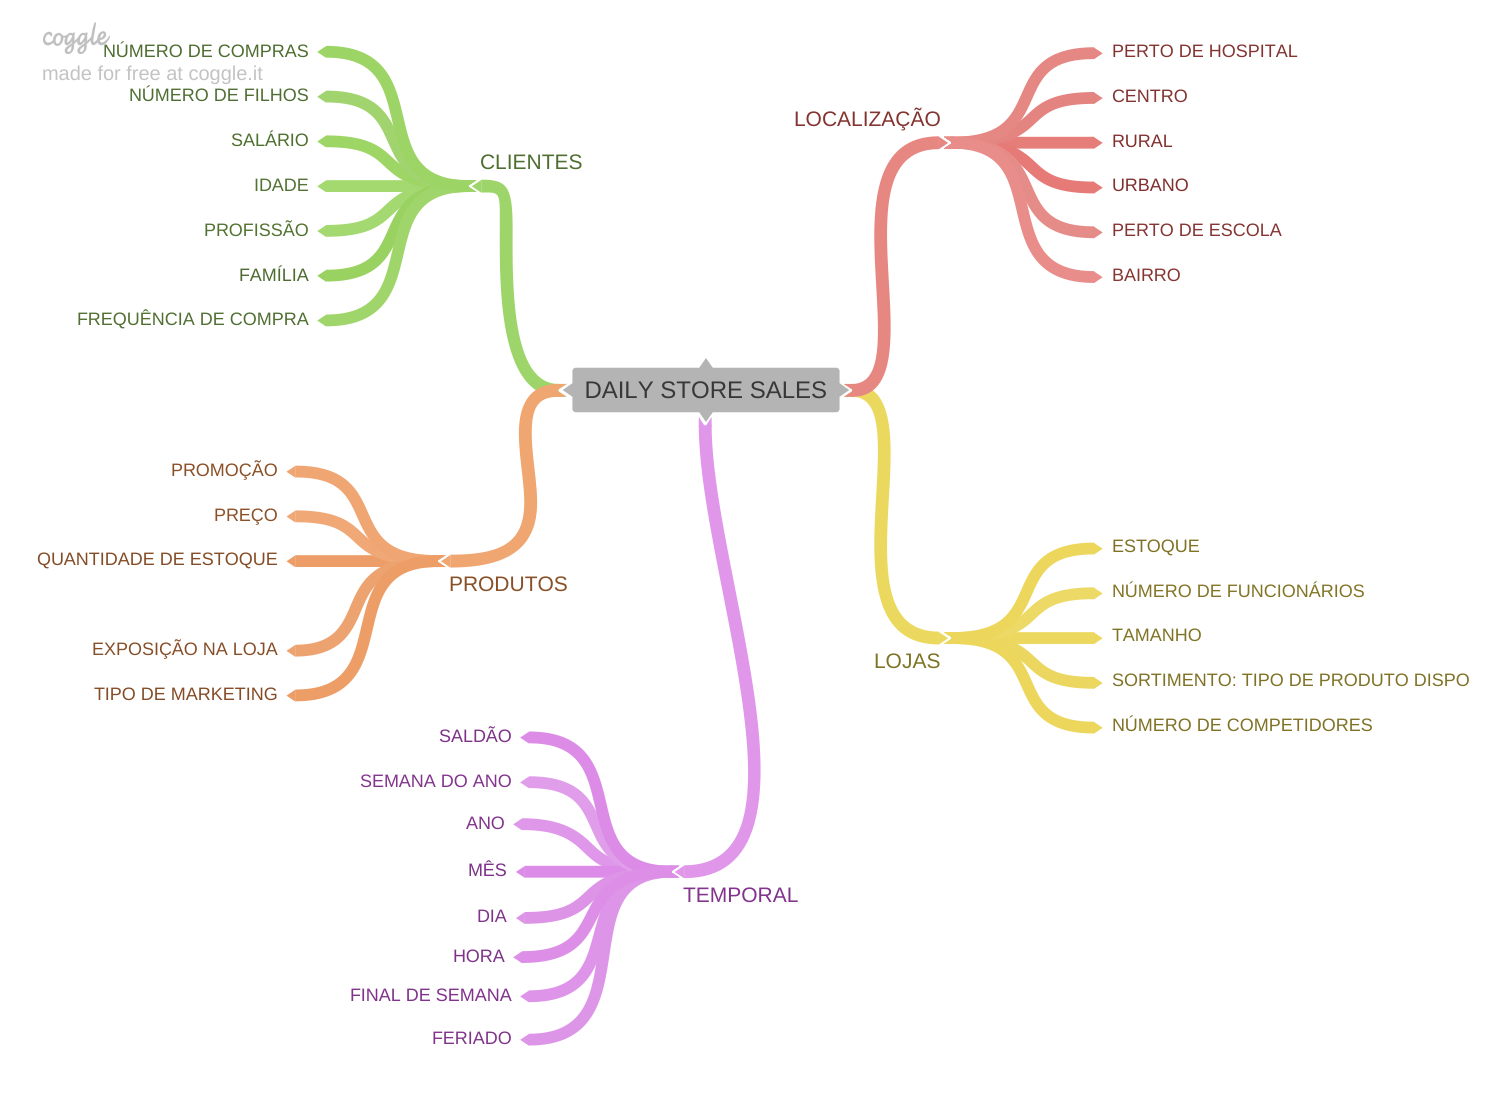

In [24]:
Image('img/mind_map.png')

## 2.1. Criação de hipóteses

### 2.1.1. Hipótese Loja

**1.** Lojas com maior número de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2. Hipótese Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que exibem mais os seus produtos deveriam vender mais.

**3.** Lojas com produtos com preços menores deveriam vender mais.

**4.** Lojas com promoções mais agressivas deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipótese Temporal (Sazonalidade)

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante as férias escolares.

## 2.2. Lista final de hipóteses

> Escolher as hipóteses que há os dados disponíveis

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante as férias escolares.

## Derivando variáveis

In [25]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.week

# year week - changing the date format
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'] , month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
# level: a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
# a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christimas' if x == 'c' else 'regular_day')

/home/gabriel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


In [26]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. Filtragem de variáveis

In [27]:
df3 = df2.copy()

Primeiro fazemos a filtragem das linhas para diminuir o volume do dataset, depois realizamos a seleção das linhas num dataset já menor

## 3.1. Filtragem das linhas

'open' só queremos as que tem valor igual a 1, pois quando tem 0 a loja não abriu, esse dado não é útil no treinamento

'open' != 0

'sales' > 0 

In [28]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das colunas

'customers', não temos esse dado no momento da predição


In [29]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

# 4.0. Análise Exploratória dos dados

In [30]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response variable

/home/gabriel/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

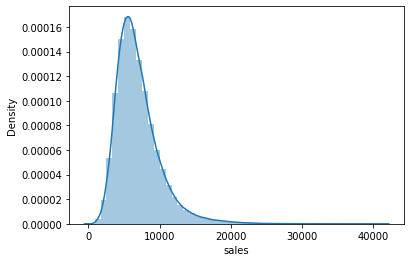

In [31]:
 sns.distplot( df4['sales'] )

### 4.1.2. Numerical variables

array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>],
       [<AxesSubplot:title={'center':'customers'}>,
        <AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'promo'}>],
       [<AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>,
        <AxesSubplot:title={'center':'competition_open_since_month'}>],
       [<AxesSubplot:title={'center':'competition_open_since_year'}>,
        <AxesSubplot:title={'center':'promo2'}>,
        <AxesSubplot:title={'center':'promo2_since_week'}>],
       [<AxesSubplot:title={'center':'promo2_since_year'}>,
        <AxesSubplot:title={'center':'is_promo2'}>, <AxesSubplot:>]],
      dtype=object)

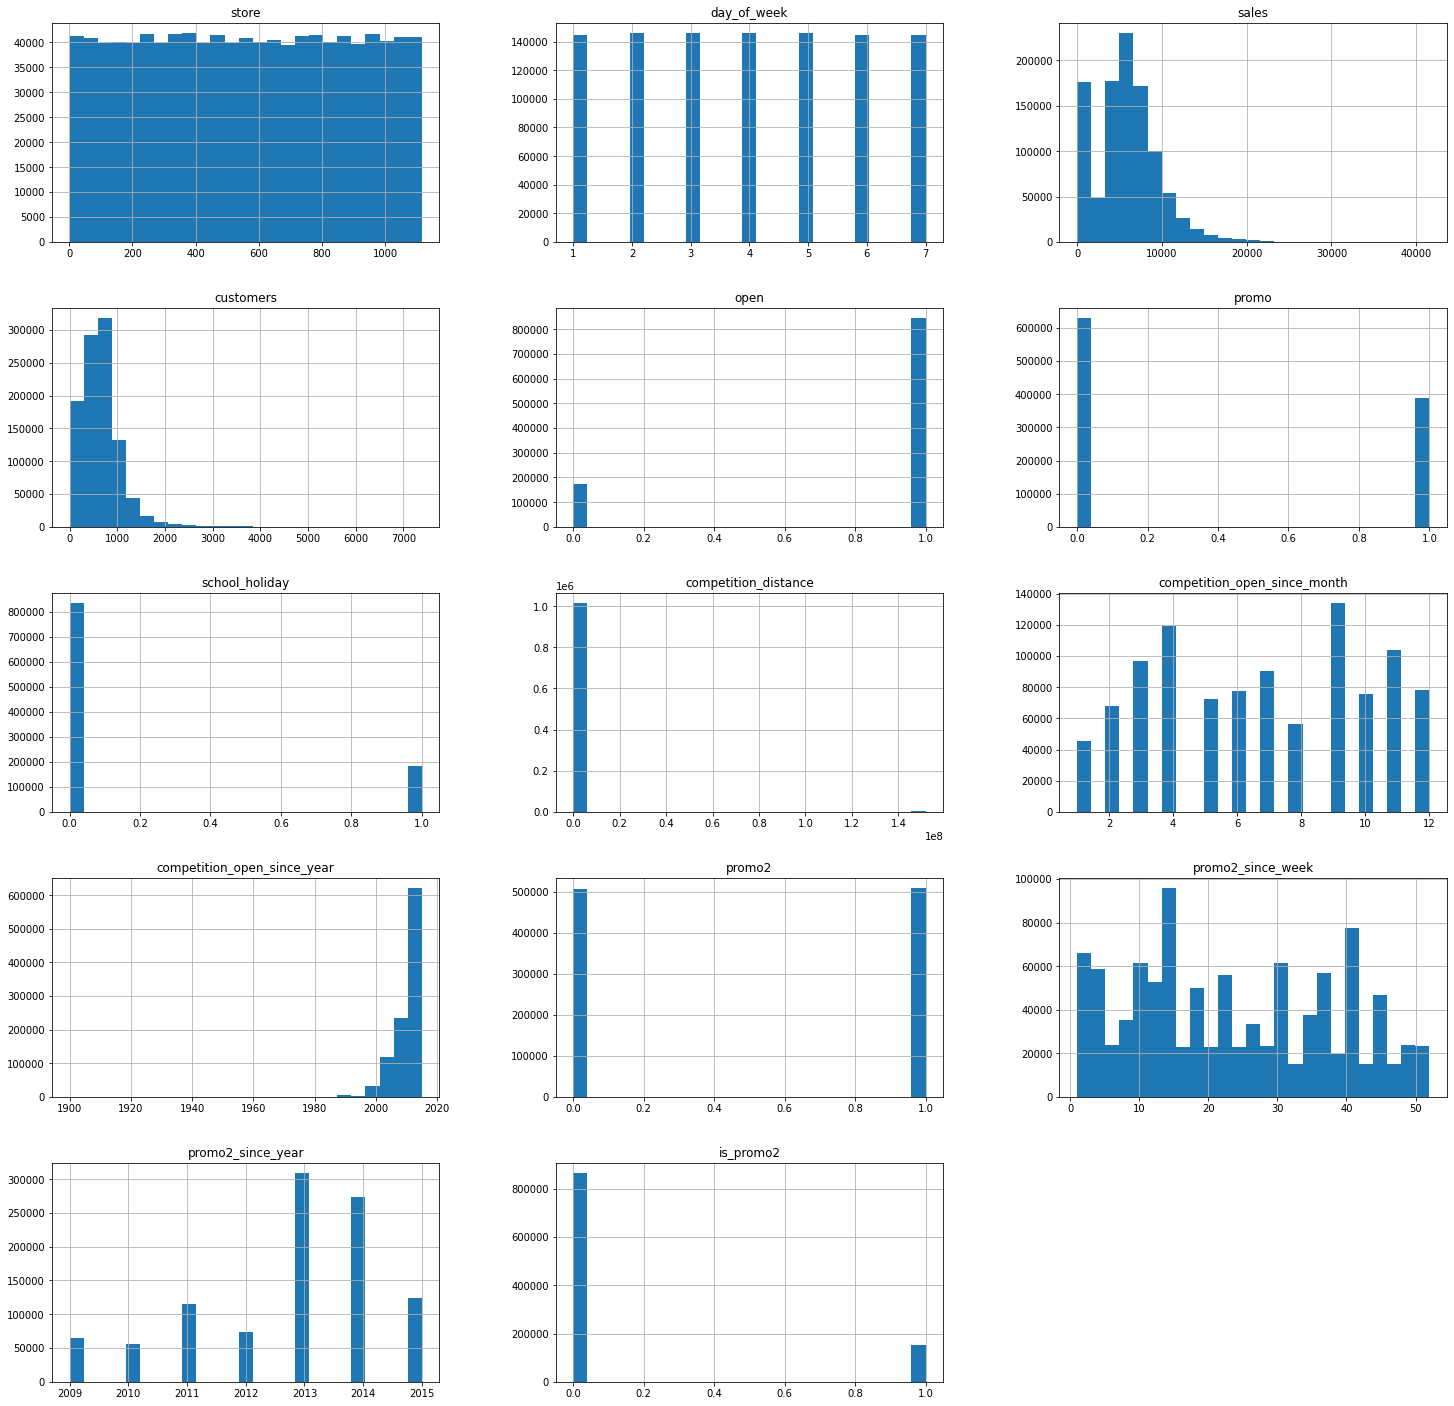

In [32]:
#num_attributes.columns
num_attributes.hist(figsize=(25,25), layout=(5,3), bins=25)

### 4.1.3. Categorical variables

In [33]:
cat_attributes.columns
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

/home/gabriel/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/gabriel/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/gabriel/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


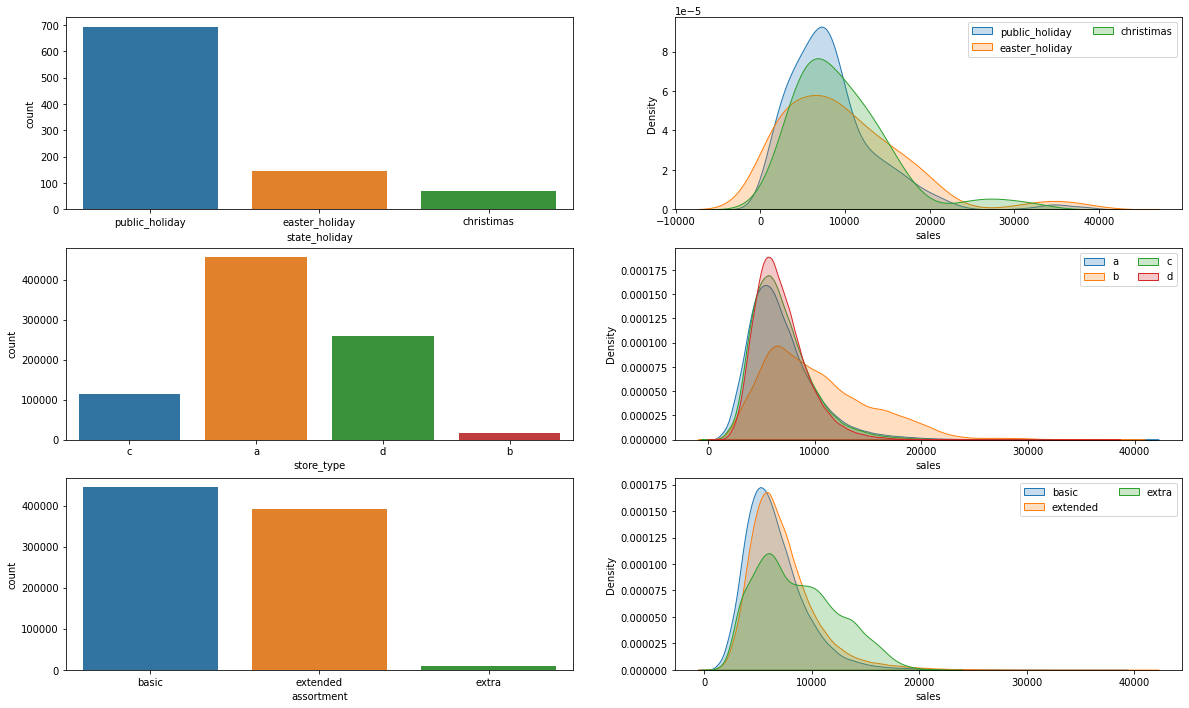

In [34]:
# state_holiday
plt.figure(figsize=(20,12))
plt.subplot(3, 2, 1)
state_holiday_without_reg_day = df4[ df4['state_holiday'] != 'regular_day']
sns.countplot( state_holiday_without_reg_day['state_holiday'] )

plt.subplot(3, 2, 2)
sns.kdeplot( df4[ df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday' , shade=True )
sns.kdeplot( df4[ df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday' , shade=True )
sns.kdeplot( df4[ df4['state_holiday'] == 'christimas']['sales'], label='christimas' , shade=True )
plt.legend(ncol=2, loc='upper right');


# store_type
plt.subplot(3, 2, 3)
sns.countplot( df4['store_type'] )

plt.subplot(3, 2, 4)
sns.kdeplot( df4[ df4['store_type'] == 'a']['sales'], label='a' , shade=True )
sns.kdeplot( df4[ df4['store_type'] == 'b']['sales'], label='b' , shade=True )
sns.kdeplot( df4[ df4['store_type'] == 'c']['sales'], label='c' , shade=True )
sns.kdeplot( df4[ df4['store_type'] == 'd']['sales'], label='d' , shade=True )
plt.legend(ncol=2, loc='upper right');


# assortment
plt.subplot(3, 2, 5)
sns.countplot( df4['assortment'] )

plt.subplot(3, 2, 6)
sns.kdeplot( df4[ df4['assortment'] == 'basic']['sales'], label='basic' , shade=True )
sns.kdeplot( df4[ df4['assortment'] == 'extended']['sales'], label='extended' , shade=True )
sns.kdeplot( df4[ df4['assortment'] == 'extra']['sales'], label='extra' , shade=True )
plt.legend(ncol=2, loc='upper right');


# 'state_holiday', 'store_type', 'assortment', 'promo_interval','month_map'


## 4.2. Análise Bivariada

### HIP 1.  Lojas com maior sortimento deveriam vender mais.

**VERDADEIRO**

Foi percebido que em volume de vendas as lojas com assortment extra vende menos, mas isso
se deve ao fato de poucas lojas possuirem tal sortimento, quando analisamos a media das
vendas das lojas em cada tipo de sortimento, percebemos que as lojas com sortimento extra
vendem mais do que as outras e que as possuem extendend assortment vendem mais que as do 
tipo basic

A quantidade de lojas com cada tipo de sortimento e: 

assortment
basic       444875
extended    391254
extra         8209
dtype: int64


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0.5, 1.0, 'Media de vendas por assortment ao longo do ano')

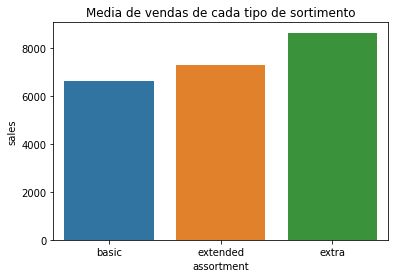

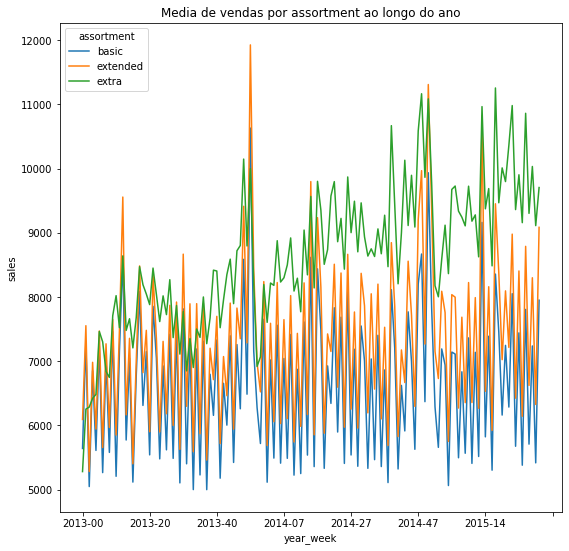

In [35]:
print('A quantidade de lojas com cada tipo de sortimento e: \n')
print(df4.groupby('assortment').size())

aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1, label='opa').set_title('Media de vendas de cada tipo de sortimento');

aux2 = df4[['assortment', 'year_week', 'sales']].groupby(['assortment','year_week']).mean().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(9,9), ylabel='sales').set_title('Media de vendas por assortment ao longo do ano')


### <s> HIP 2. Lojas com competidores mais próximos deveriam vender menos. </s>

Inconclusivo, dificil perceber uma relação entre a distância e as vendas

AttributeError: 'Text' object has no attribute 'get_ylim'

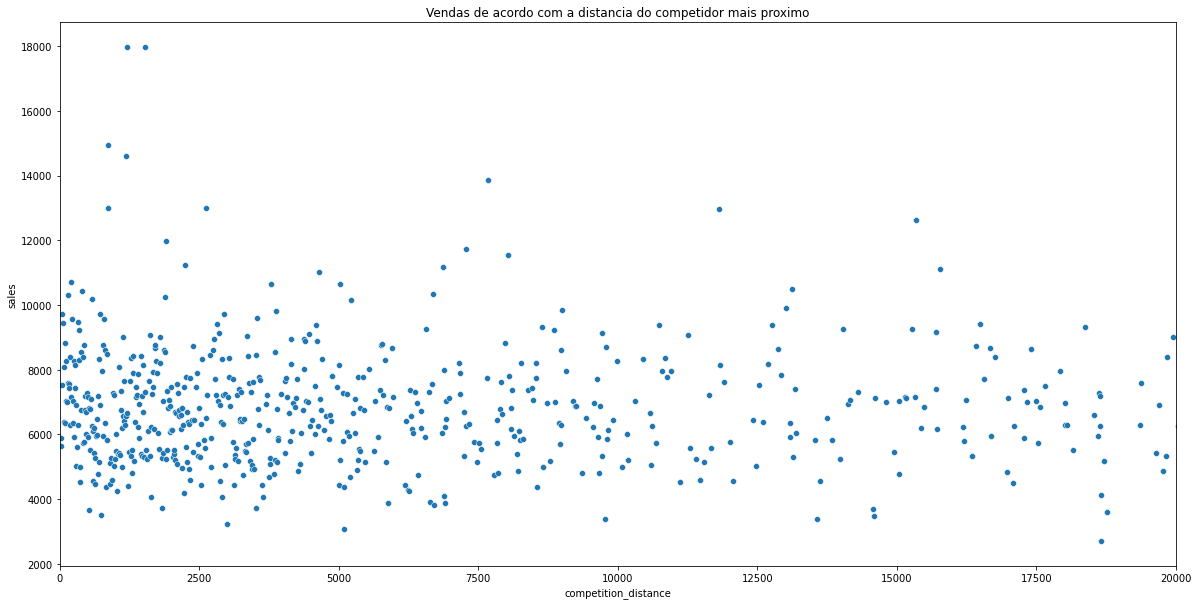

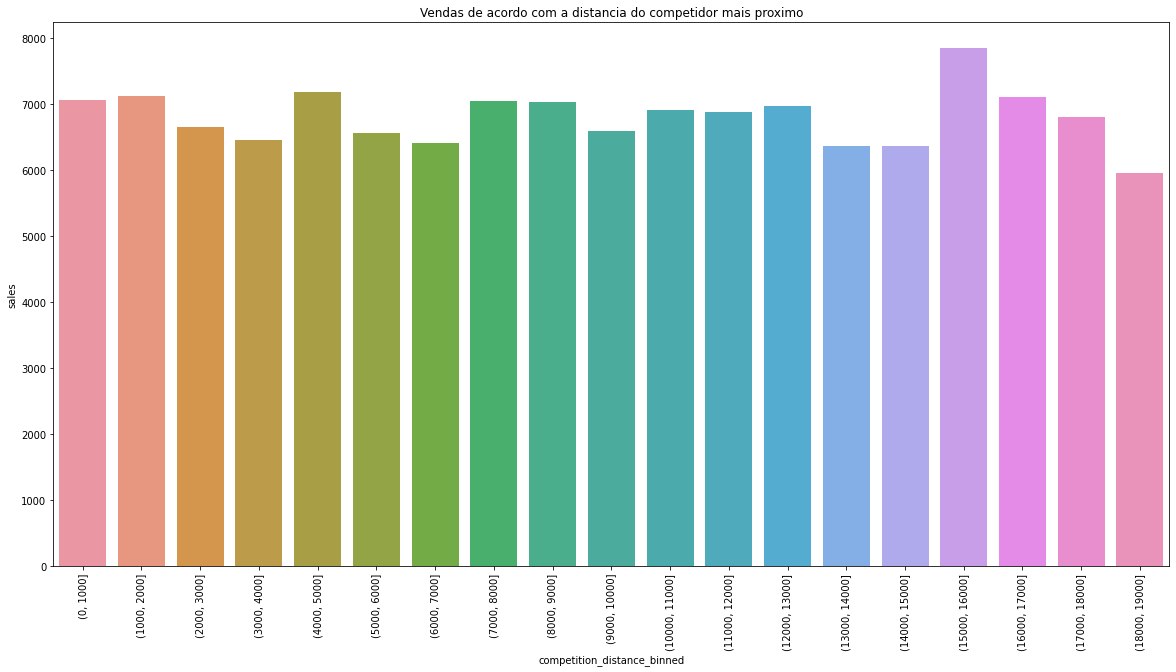

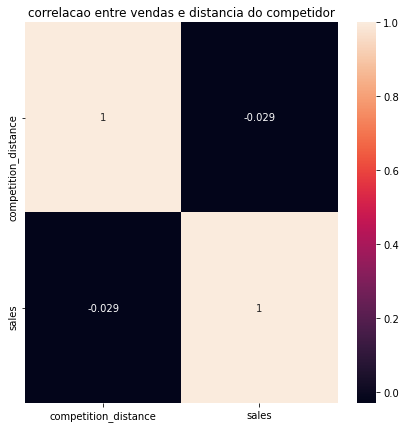

In [39]:
aux = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

# scatter plot
plt.figure(figsize=(20,10))
plt.xlim(0, 20000)
sns.scatterplot(x='competition_distance', y='sales', data=aux).set_title('Vendas de acordo com a distancia do competidor mais proximo')


# barplot
bins = list( np.arange(0, 20000, 1000) )

aux['competition_distance_binned'] = pd.cut( aux['competition_distance'], bins=bins)
aux2 = aux[['competition_distance_binned','sales']].groupby('competition_distance_binned').mean().reset_index()
plt.figure(figsize=(20,10))
plt.xticks( rotation='90' )
sns.barplot(x='competition_distance_binned', y='sales', data=aux2).set_title('Vendas de acordo com a distancia do competidor mais proximo')


# heatmap
plt.figure(figsize=(7,7))
x = sns.heatmap( aux.corr( method='pearson'), annot=True).set_title('correlacao entre vendas e distancia do competidor');
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5)


### HIP 3. Lojas com competidores a mais tempo deveriam vender mais.

**VERDADEIRO** - Lojas com competidores a mais tempo vendem mais

AttributeError: 'Text' object has no attribute 'get_ylim'

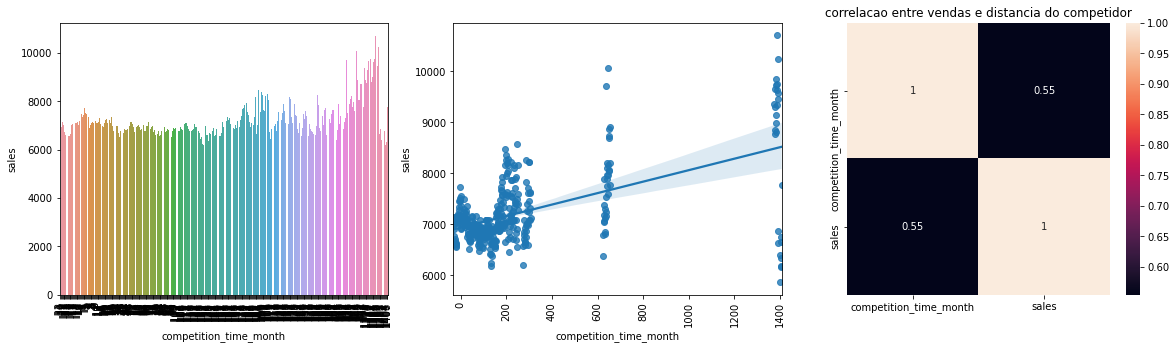

In [40]:
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').mean().reset_index()
aux2 = aux1[ (aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0) ]

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.xticks(rotation=90)
sns.barplot(x='competition_time_month', y='sales', data=aux1)


#plt.figure(figsize=(25,7))
plt.subplot(1,3,2)
plt.xticks(rotation=90)
sns.regplot(x='competition_time_month', y='sales', data=aux1)


#plt.figure(figsize=(7,7))
plt.subplot(1,3,3)
x = sns.heatmap( aux1.corr( method='pearson'), annot=True).set_title('correlacao entre vendas e distancia do ');
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5)

### HIP 4. Lojas com promoções ativas por mais tempo deveriam vender mais.


**VERDADEIRO** Todas as vendas com promo time negativo sao vendas feitas no periodo da promocao
tradicional, sem incluir o periodo da promocao estendida que e a promo2

Text(0.5, 1.0, '\nPeriodo total')

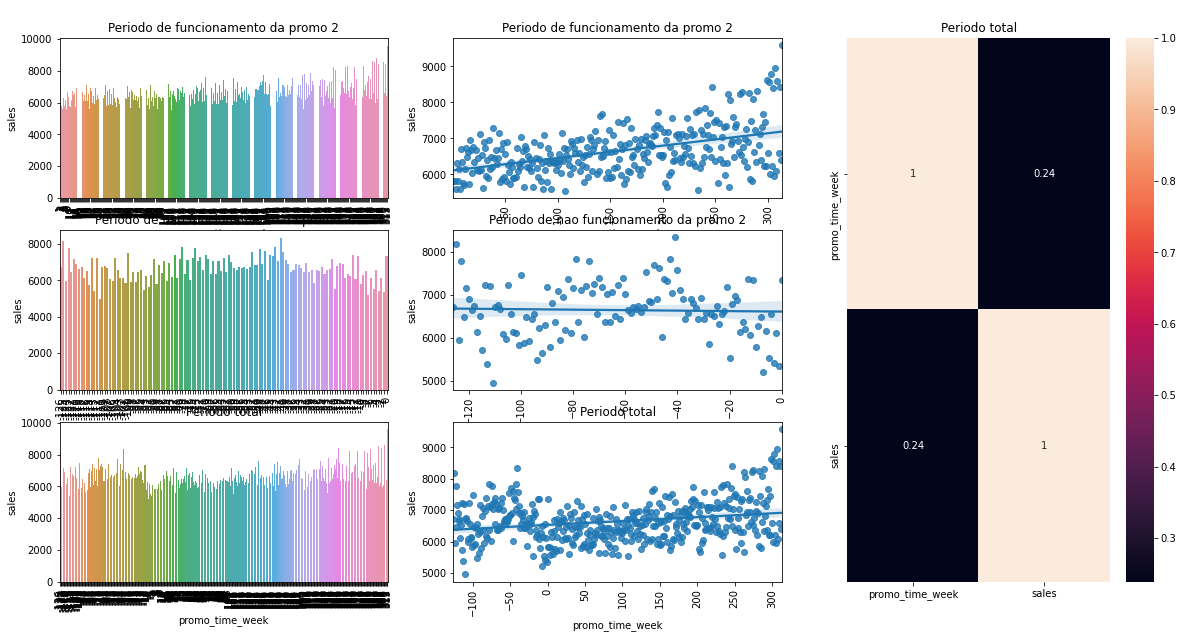

In [41]:
aux = df4[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()
aux2 = aux[ (aux['promo_time_week'] > 0) ]
aux3 = aux[ (aux['promo_time_week'] <= 0) ]

grid = plt.GridSpec(3,3)

# promo 2 ativa
plt.figure(figsize=(20,10))
plt.subplot(grid[0,0])
plt.xticks(rotation=90)
sns.barplot(x='promo_time_week', y='sales', data=aux2).set_title('Periodo de funcionamento da promo 2')

plt.subplot(grid[0,1])
plt.xticks(rotation=90)
sns.regplot(x='promo_time_week', y='sales', data=aux2).set_title('Periodo de funcionamento da promo 2')


# promo 2 nao ativa
plt.subplot(grid[1,0])
plt.xticks(rotation=90)
sns.barplot(x='promo_time_week', y='sales', data=aux3).set_title('Periodo de nao funcionamento da promo 2')

plt.subplot(grid[1,1])
plt.xticks(rotation=90)
sns.regplot(x='promo_time_week', y='sales', data=aux3).set_title('Periodo de nao funcionamento da promo 2')


# promo 2 periodo total
plt.subplot(grid[2,0])
plt.xticks(rotation=90)
sns.barplot(x='promo_time_week', y='sales', data=aux).set_title('\nPeriodo total')

plt.subplot(grid[2,1])
plt.xticks(rotation=90)
sns.regplot(x='promo_time_week', y='sales', data=aux).set_title('\nPeriodo total')

plt.subplot(grid[:,2])
sns.heatmap(aux.corr(method='pearson'), annot=True).set_title('\nPeriodo total')

### HIP 5. Lojas com mais dias de promoção deveriam vender mais.


### [bom insight] HIP 6. Lojas com mais promoções consecutivas deveriam vender mais.


**FALSA** Lojas com mais promoções consecutivas vendem menos

In [42]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).mean().reset_index()

,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5529.566684
2,1,0,8618.452062
3,1,1,7836.672987


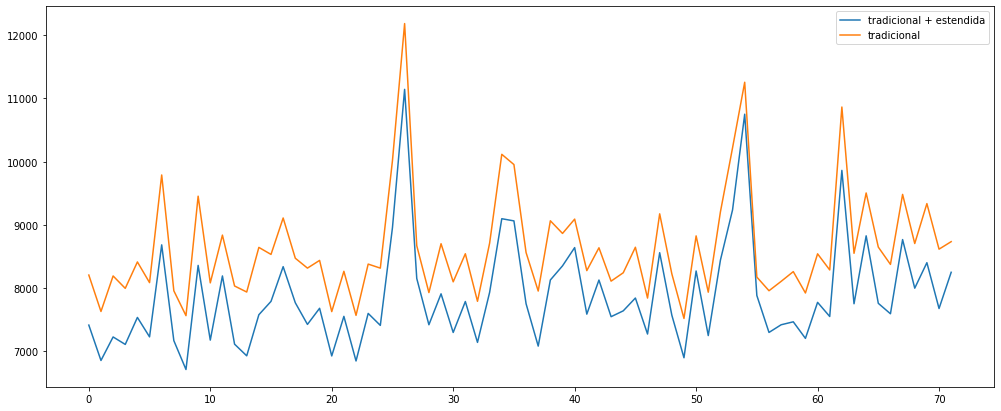

In [43]:
aux = df4[ (df4['promo'] == 1) & (df4['promo2'] == 1) ][['year_week', 'sales']].groupby('year_week').mean().reset_index()
ax = aux.plot(figsize=(17,7))

aux2 = df4[ (df4['promo'] == 1) & (df4['promo2'] == 0) ][['year_week', 'sales']].groupby('year_week').mean().reset_index()
aux2.plot(figsize=(17,7), ax=ax)

ax.legend(['tradicional + estendida', 'tradicional'])


### HIP 7. Lojas abertas durante o feriado de Natal deveriam vender mais.

**VERDADEIRO** No feriado de natal e de páscoa as vendas por dia são as maiores do ano - Talvez não seja um insight pois
há uma grande do pessoal de vendas saber acerca disso.

In [ ]:
aux = df4[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
plt.figure(figsize=(15,7))
sns.barplot(x='state_holiday', y='sales', data=aux).set_title('Venda média dos tipos de dias')

plt.figure(figsize=(15,7))
aux2 = df4[['state_holiday', 'year', 'sales']].groupby(['year','state_holiday']).mean().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2).set_title('Venda média do tipo de dia ao longo dos anos')


### HIP 8. Lojas deveriam vender mais ao longo dos anos.



**FALSO** As lojas vendem menos ao longo dos anos - Não forma um insight, pois o pessoal de vendas e negócios já sabem
acerca desse fenômeno

<AxesSubplot:>

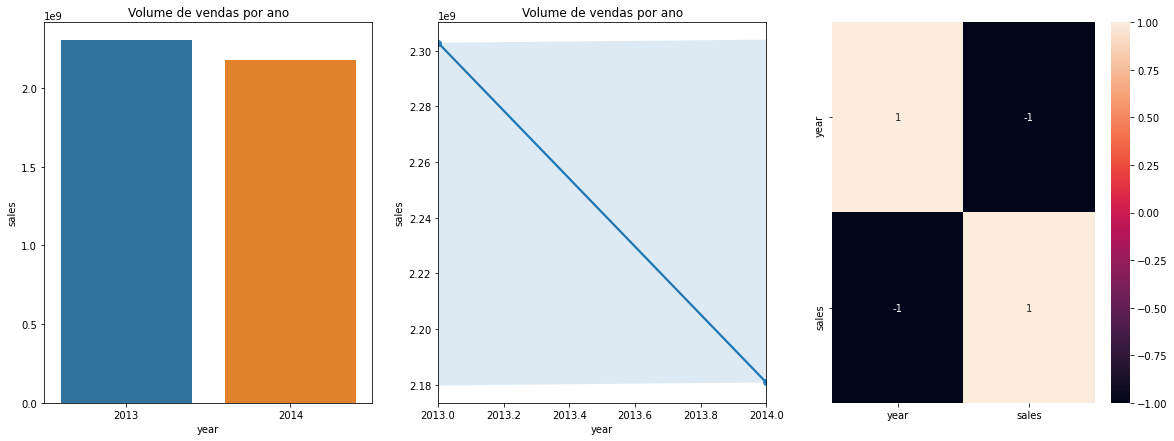

In [44]:
aux = df4[df4['year'] != 2015][['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux).set_title('Volume de vendas por ano')

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux).set_title('Volume de vendas por ano')

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True)

### HIP 9. Lojas deveriam vender mais no segundo semestre do ano.


**VERDADEIRO** As lojas vendem mais no segundo semestre do ano - Não gera um insight, pelo mesmo motivo do anterior.

Text(0.5, 1.0, 'Vendas mensais no período 2013-2014')

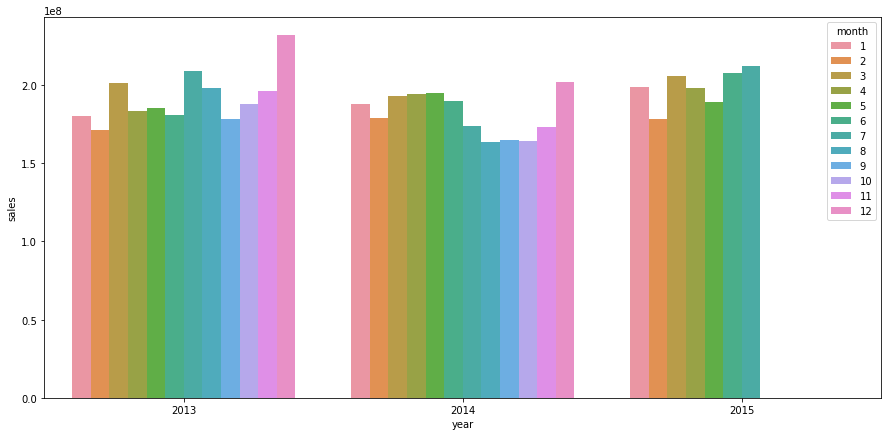

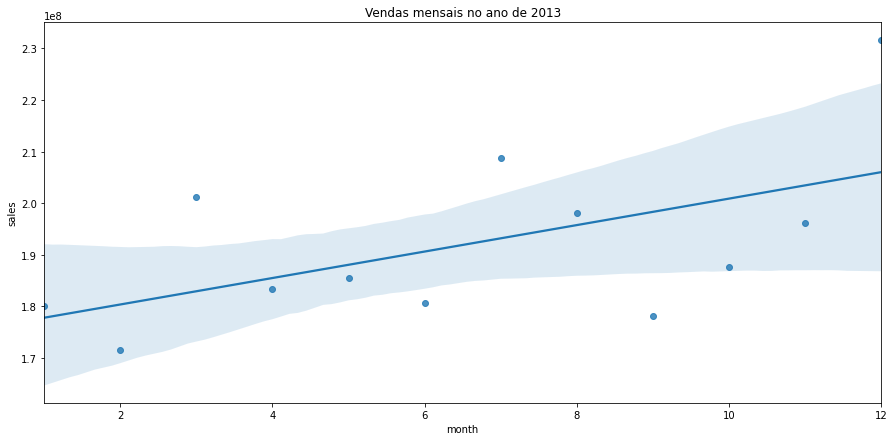

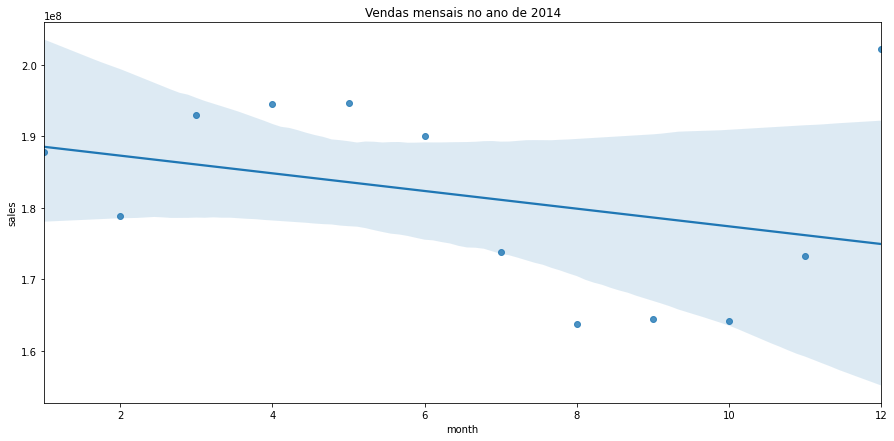

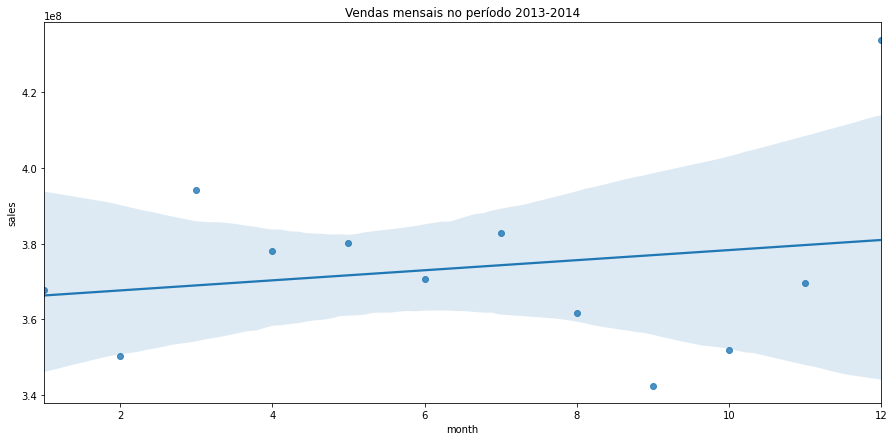

In [45]:
aux = df4[ ['year','month', 'sales'] ].groupby(['year', 'month']).sum().reset_index()
plt.figure(figsize=(15,7))
sns.barplot(x='year', y='sales', hue='month', data=aux)

aux2 = df4[ df4['year'] == 2013 ][ ['month', 'sales'] ].groupby('month').sum().reset_index()
plt.figure(figsize=(15,7))
sns.regplot(x='month', y='sales', data=aux2).set_title('Vendas mensais no ano de 2013')

aux3 = df4[ df4['year'] == 2014 ][ ['month', 'sales'] ].groupby('month').sum().reset_index()
plt.figure(figsize=(15,7))
sns.regplot(x='month', y='sales', data=aux3).set_title('Vendas mensais no ano de 2014')

aux3 = df4[ df4['year'] != 2015 ][ ['month', 'sales'] ].groupby('month').sum().reset_index()
plt.figure(figsize=(15,7))
sns.regplot(x='month', y='sales', data=aux3).set_title('Vendas mensais no período 2013-2014')

### HIP 10. Lojas deveriam vender mais depois do dia 10 de cada mês.


**FALSO** Separando o mês em 3 partes, os 10 primeiros dias apresenta a maior média de vendas dos 3 períodos, desconsiderando os feriados - Não gera um insight pelo mesmo motivo anterior.

<AxesSubplot:>

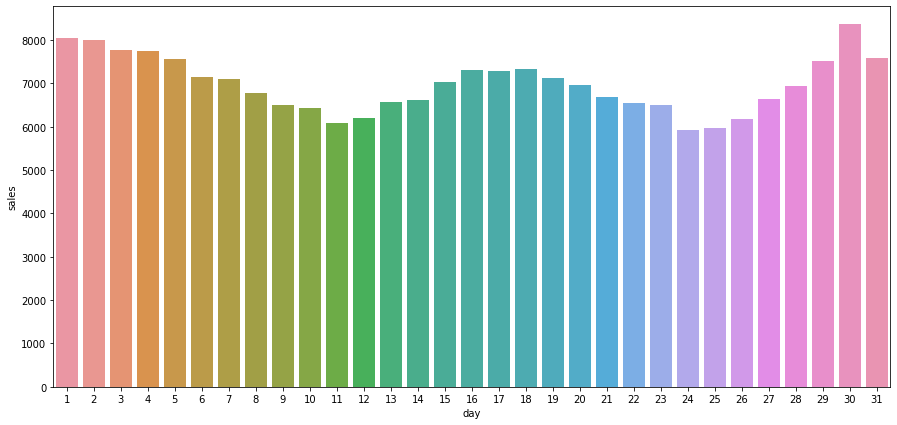

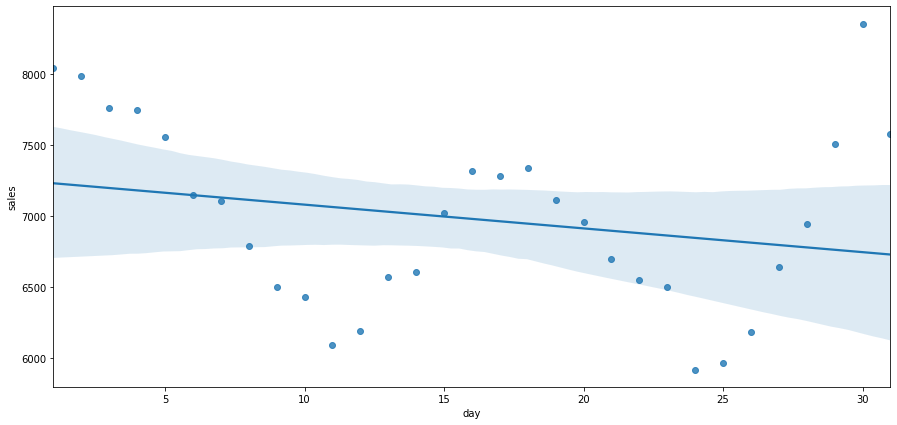

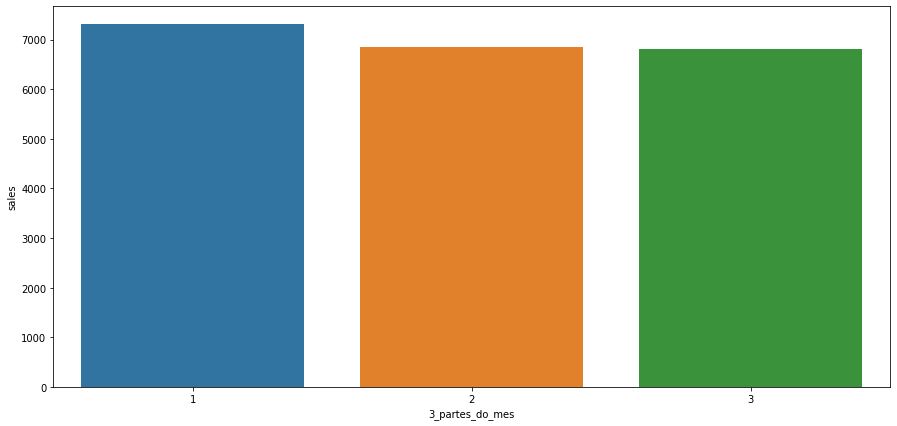

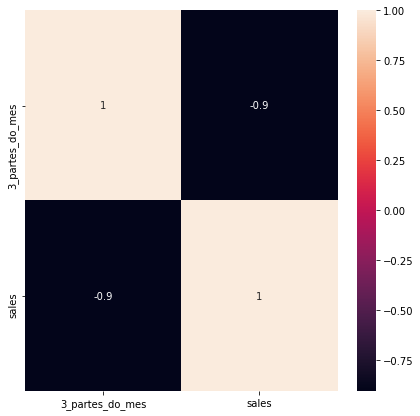

In [46]:
aux = df4[ df4['state_holiday'] == 'regular_day' ][['day','sales']].groupby('day').mean().reset_index()
plt.figure(figsize=(15,7))
sns.barplot(x='day', y='sales', data=aux)

plt.figure(figsize=(15,7))
sns.regplot(x='day', y='sales', data=aux)

aux['3_partes_do_mes'] = aux['day'].apply(lambda x: 1 if x <= 10 else 2 if ((x > 10) & (x <= 20 )) else 3)
aux2 = aux[['3_partes_do_mes', 'sales']].groupby('3_partes_do_mes').mean().reset_index()
plt.figure(figsize=(15,7))
sns.barplot(x='3_partes_do_mes', y='sales', data=aux2)

plt.figure(figsize=(7,7))
sns.heatmap(aux2.corr(method='pearson'), annot=True)

### HIP 11. Lojas deveriam vender menos aos finais de semana.


**FALSO** Das lojas que vendem ao domingo, estas apresentam a maior quantidade de vendas em relação aos demais 
dias da semana - Não gera um insight pelo mesmo motivo anterior.

   day_of_week        sales
0            1  8216.252259
1            2  7088.409086
2            3  6728.786679
3            4  6768.214973
4            5  7073.034133
5            6  5875.084935
6            7  8224.723908
6    144052
2    143955
3    141922
5    138633
1    137557
4    134626
7      3593
Name: day_of_week, dtype: int64


<AxesSubplot:>

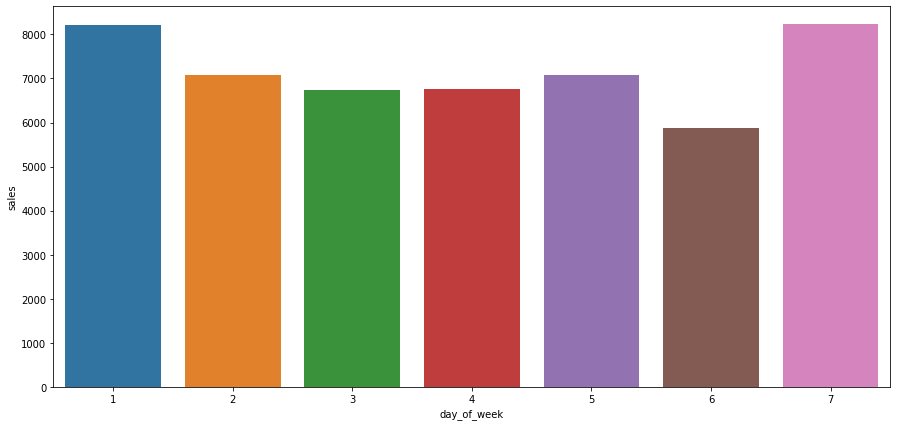

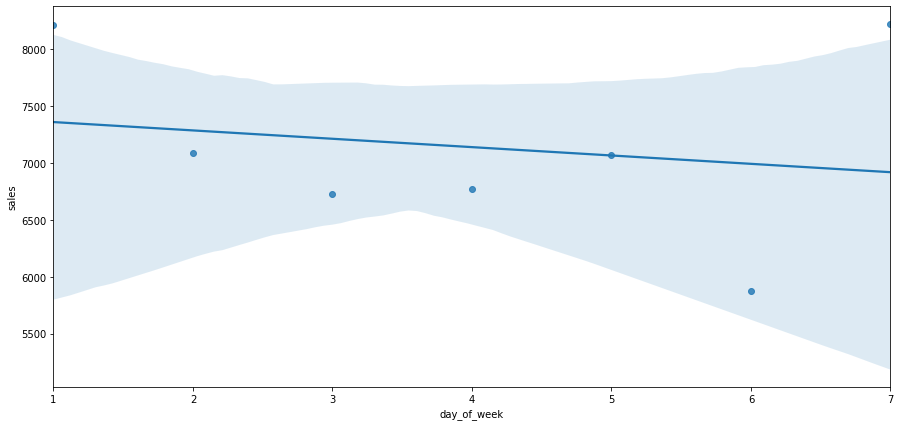

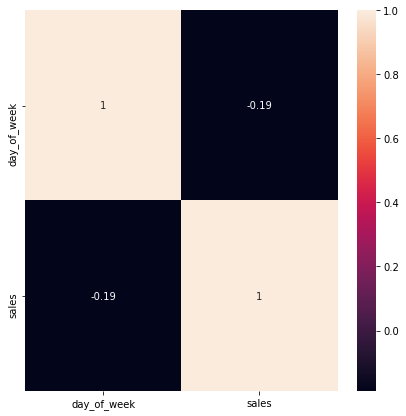

In [47]:
aux = df4[['day_of_week', 'sales']].groupby('day_of_week').mean().reset_index()
print(aux)

print(df4['day_of_week'].value_counts())

plt.figure(figsize=(15,7))
sns.barplot(x='day_of_week', y='sales', data=aux)

plt.figure(figsize=(15,7))
sns.regplot(x='day_of_week', y='sales', data=aux)

plt.figure(figsize=(7,7))
sns.heatmap(aux.corr(method='pearson'), annot=True)

### HIP 12. Lojas deveriam vender menos durante as férias escolares.

**FALSO** Durante os dias que não há aulas escolares, as lojas vendem mais - Não gera um insight pelo mesmo motivo anterior

In [ ]:
aux = df4[['school_holiday','sales']].groupby('school_holiday').mean().reset_index()

plt.figure(figsize=(15,7))
sns.barplot(x='school_holiday', y='sales', data=aux)

plt.figure(figsize=(15,7))
sns.regplot(x='school_holiday', y='sales', data=aux)

plt.figure(figsize=(7,7))
sns.heatmap(aux.corr(method='pearson'), annot=True)

aux2 = df4[['school_holiday','sales', 'month']].groupby(['school_holiday', 'month']).mean().reset_index()

plt.figure(figsize=(15,7))
sns.barplot(x='month', y='sales', hue='school_holiday',data=aux2)


aux3 = df4[['school_holiday','sales', 'month']].groupby(['school_holiday', 'month']).sum().reset_index()

plt.figure(figsize=(15,7))
sns.barplot(x='month', y='sales', hue='school_holiday',data=aux3)



### RESUMO DAS HIPÓTESES

ModuleNotFoundError: No module named 'tabulate'

## 4.3. Análise Multivariada